In [30]:
import math
import torch
from torch import nn
from d2l import torch as d2l

In [31]:
num_hiddens, num_heads = 100, 5
attention = d2l.MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens,
                                   num_hiddens, num_heads, 0.5)
attention.eval()

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [32]:
batch_size, num_queries, valid_lens = 2, 4, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
attention(X, X, X, valid_lens).shape

torch.Size([2, 4, 100])

位置编码 position embedding

In [37]:
class PositionalEncoding(nn.Module):
    def __init__(self, num_hiddens, dropout, max_len=1000) -> None:
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)

        # p:  [ batch_size, num_semple, num_feature ]
        self.P = torch.zeros((1, max_len, num_hiddens))

        # X是一个最大长度的序列
        # 其中： i = maxlen的序列， j就是特征长度的序列缩放到0~2之间，d就是总特征长度
        X = torch.arange(max_len, dtype=torch.float32).reshape(-1, 1)
        X = X / torch.pow(10000, torch.arange(0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        # x.shape[1]只取前num-steps个有需求的编码
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        
        # 使用dropout进一步减小X对于P的以依赖
        return self.dropout(X)
        

在位置嵌入矩阵P中，行代表词元在序列中的位置，列代表位置编码的不同维度。\
在下面的例子中，我们可以看到位置嵌入矩阵的第6列和第7列的频率高于第8列和第9列。\
第6列和第7列之间的偏移量（第8列和第9列相同）是由于正弦函数和余弦函数的交替。

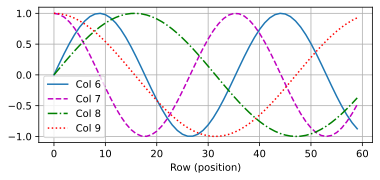

In [38]:
encoding_dim, num_steps = 32, 60

pos_encoding = PositionalEncoding(encoding_dim, 0)
pos_encoding.eval()

# 只要num_steps小于最大长度 都可以返回position embedding
X = pos_encoding(torch.zeros((1, num_steps, encoding_dim)))
P = pos_encoding.P[:, :X.shape[1], :]

d2l.plot(torch.arange(num_steps), P[0, :, 6:10].T, xlabel='Row (position)',
         figsize=(6, 2.5), legend=["Col %d" % d for d in torch.arange(6, 10)])

绝对位置信息

In [39]:
for i in range(8):
    print(f'{i}的二进制是：{i:>03b}')

0的二进制是：000
1的二进制是：001
2的二进制是：010
3的二进制是：011
4的二进制是：100
5的二进制是：101
6的二进制是：110
7的二进制是：111


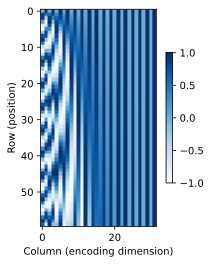

In [40]:
P = P[0, :, :].unsqueeze(0).unsqueeze(0)
d2l.show_heatmaps(P, xlabel='Column (encoding dimension)',
                  ylabel='Row (position)', figsize=(3.5, 4), cmap='Blues')

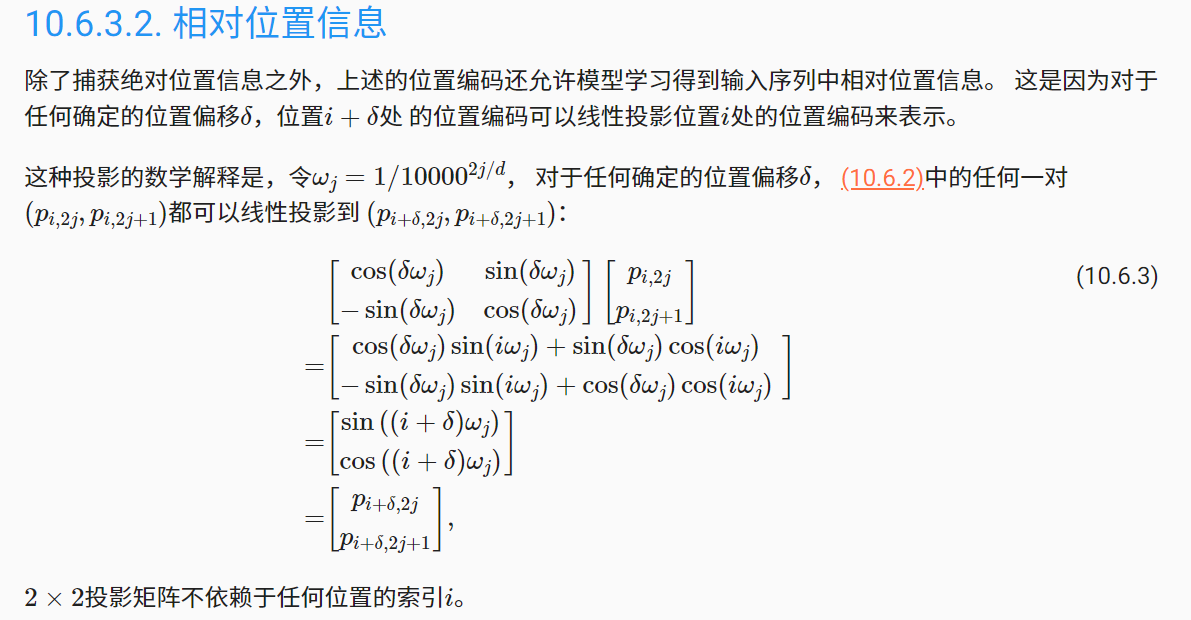

In [42]:
from IPython.display import Image
Image(filename = 'E:\Clancy\Code\动手学深度学习NLP篇\\selfattention.png', width=10, height=10)